In [1]:
import pylab
import numpy as np
import copy

from tqdm import tqdm

In [2]:
import gc
import xlrd
import xlwt

In [3]:
import torch
import transformers
import sklearn as skl

In [4]:
import emotion
import parsing

In [5]:
LabtoNum = {'радость' : 0 , 'восхищение' : 1, 'злость' : 2, 'грусть' : 3,
       'удивление' : 4, 'ожидание' : 5, 'отвращение' : 6, 'страх' : 7, 'нет эмоций' : 8}

NumToLab = { 0 : 'радость', 1 : 'восхищение', 2 : 'злость', 3 : 'грусть', 4 : 'удивление', 5 : 'ожидание',
       6 : 'отвращение', 7 : 'страх', 8 : 'нет эмоций'}

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
main_detector = emotion.emotion_detector(9,4)
main_detector.load_('models/trained_detector')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassi

In [8]:
main_detector.bert.config.label2id = LabtoNum
main_detector.bert.config.id2label = NumToLab

In [9]:
def display_probs(sent):
    scores = main_detector.scores(sent)
    fig = pylab.figure(figsize = [7,3])
    fig.suptitle(sent)
    pylab.ylim(0,1)
    pylab.bar(range(len(scores)),scores, tick_label = list(LabtoNum.keys()))
    pylab.xticks(rotation = 40)

In [10]:
sent = 'Как же здорово, что все мы здесь сегодня собрались'

In [11]:
sent = '...'

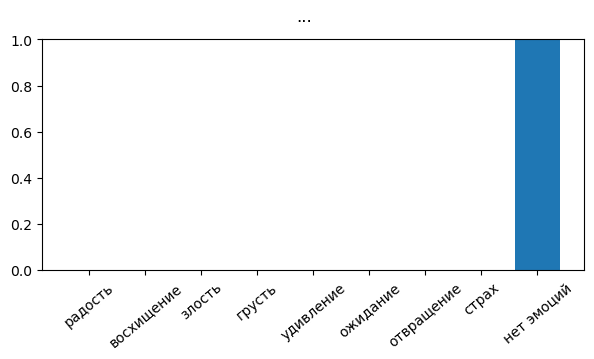

In [12]:
display_probs(sent)

In [13]:
document = parsing.import_text('chapter1')

In [14]:
my_parser = parsing.text_parser(document)
my_parser.extract_utterances_and_tokenise()
my_parser.extract_actor_words_from_utterances()
my_parser.format_actors_in_text()
my_parser.construct_actor_objects()

In [15]:
for sent in my_parser.utterances:
    sent.emotion = main_detector.scores(sent.text)

In [16]:
maxpos = max([utt.position_in_text for utt in my_parser.utterances])

In [17]:
def actor_utterances(actor):
    for act in my_parser.referents:
        if(actor in act.names):
            return act.utterances

In [18]:
colors = [(0.9,0.9,0.0),'w','r','b','c','o','m',(0.0,0.8,0.0),'b']

In [19]:
def plot_emotions(character,emo = []):
    
    utteraces = actor_utterances(character)
    
    char_emotion_trace = []
    for utt in utteraces:
        char_emotion_trace.append([utt.position_in_text] + utt.emotion.tolist())      
    char_emotion_trace = np.array(sorted(char_emotion_trace))
            
    fig = pylab.figure(figsize = [10,3])
    fig.suptitle(character)
    pylab.xlim([0,maxpos])
    pylab.ylim([0,1])
    
    if emo == []:
        emo_ids = range(8)
    else:
        emo_ids = []
        for e in emo:
            emo_ids.append(main_detector.bert.config.label2id[e])
            
    for emo_id in emo_ids:
        emo_id += 1

        pylab.plot(char_emotion_trace[:,0], char_emotion_trace[:,emo_id],
                   label = main_detector.bert.config.id2label[emo_id - 1],
                   color = colors[emo_id - 1])
        
        
    pylab.grid()
    pylab.legend(bbox_to_anchor=(1.005, 1))
    pylab.show()

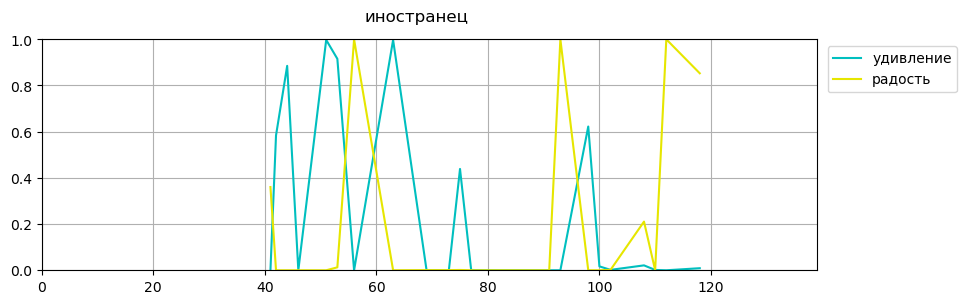

In [20]:
plot_emotions('иностранец',['удивление','радость'])

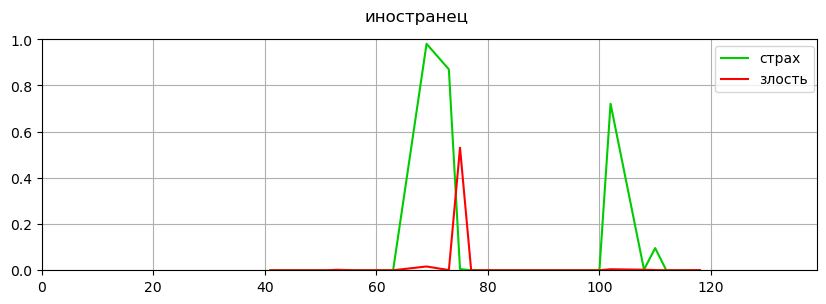

In [21]:
plot_emotions('иностранец',['страх','злость'])

In [57]:
def make_emo_table(name):
    wb = xlwt.Workbook()

    sheet = wb.add_sheet('sheet1')

    for index in range(len(my_parser.utterances)):
        utterance = my_parser.utterances[index]
        
        sheet.write(index,0,utterance.position_in_text)
        sheet.write(index,1,utterance.text)
        sheet.write(index,2,NumToLab[np.argmax(utterance.emotion)])
        
        
        if(utterance.actor != None):
            sheet.write(index,3,utterance.actor.names[0])
               
        for ind in range(9):
            sheet.write(index,4 + ind, str(utterance.emotion[ind]))
    
    wb.save(name)

In [58]:
make_emo_table('emo_table.xlsx')

In [ ]:
def make_emo_table(name):
    wb = xlwt.Workbook()

    sheet = wb.add_sheet('sheet1')

    for index in range(len(my_parser.utterances)):
        utterance = my_parser.utterances[index]
        
        sheet.write(index,0,utterance.position_in_text)
        sheet.write(index,1,utterance.text)
        sheet.write(index,2,NumToLab[np.argmax(utterance.emotion)])
        
        names = ''
        if(utterance.actor != None):
            for name in utterance.actor.names:
                names += name + ' | '
                
            sheet.write(index,3,names)
        
        for ind in range(9):
            sheet.write(index,4 + ind, str(utterance.emotion[ind]))
    
    print('saving...')
    wb.save(name)